In [5]:
import torch
from torch_geometric.data import Data
import numpy as np
import networkx as nx
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
import matplotlib.pyplot as plt
import scipy.special as SS
import pandas as pd
import scipy.stats as SSA

In [17]:
def superspreading_T_Loc_real_seed(T, nbi_para, pop, paras, file_path, rand_seed, NewInf, TotInf, ti):
    
    ##################Initialise#################
    Z, Zb, D, Db = paras
    r, P_ts = nbi_para
    child_seeds = rand_seed.spawn(T)
    p_ti = P_ts.iloc[ti].values[1:]
    date_parts = P_ts.iloc[ti]['Date'].split('-')
    y, m, d = date_parts
    num_fips = len(pop)
    #################Mobility#######################
    M_test = np.loadtxt(file_path+'M_{}{}_{}.csv'.format(y,m,d),delimiter=',')
    M_pop = M_test/pop_sorted[None,:]
    #if there is no one go out from one site
    temp = np.sum(M_pop,axis=0)
    if np.sum(temp == 0) == 0:
        M_pop_norm = M_pop/temp[None,:]
    else:
#             print('there is no one go out from one site')
        mask = temp == 0
        temp[mask]=1
        M_pop_norm = M_pop/temp[None,:]
        M_pop_norm[:,mask] = 0
        M_pop_norm[mask,mask] = 1
#         WN_small = M_pop_norm[:100,:100]
    WN = M_pop_norm #WN_small/np.sum(WN_small,axis=0)[None,:]
    ########################################
    infectors = np.int64(NewInf[:, ti])
    pop_immu = 1-TotInf[:, ti]/pop[:]
    pop_immu[pop_immu < 0] = 0

    rng = np.random.default_rng(child_seeds[ti])
    totoal_new_infection_loc = []
    total_new = 0
    for i in range(num_fips):
        infectors_loc_i = infectors[i]
        if infectors_loc_i>0:
#                 print(i,infectors_loc_i)
            xx = np.arange(0, 100, 1)  # define the range of x values the
            p = p_ti[i]
            pmf = SSA.nbinom.pmf(xx, r, p)
            weights_n = pmf/np.sum(pmf)
            ttt = np.random.choice(len(weights_n), size=infectors_loc_i, p=weights_n) #np.array([2]*infectors_loc_i) # #rng
            new_array = np.round(ttt*pop_immu[i])
            if len(new_array)>0:
#                     print(ttt)
                new_s = np.int64(np.sum(new_array))

                totoal_new_infection_loc.extend([i]*new_s)
                total_new = total_new + new_s
    # to be assigned, every new infections for the infector
#         total_new = np.round(tt*immu_all)
#         totoal_new_infection_loc = get_new_infections_position(
#             infectors, total_new, num_fips)
    z_num = np.int64(total_new)

    NF = np.zeros((2, z_num), dtype=np.int64)
    # for the time distribution
    latency_p = SSA.gamma.rvs(a=Z, scale=Zb, size=z_num, random_state=rng)
    infectious_p = SSA.gamma.rvs(
        a=D, scale=Db, size=z_num, random_state=rng)
    v = rng.random(z_num)
    delay_days = latency_p+v*infectious_p #latency_p+v*infectious_p  # 3+5*0.5

    NF[0, :] = np.ceil(delay_days+ti)  # make it idx int
    # for the location distribution
    NF[1, :] = totoal_new_infection_loc
    df = pd.DataFrame(NF.T, columns=['time', 'o_l'])
    l_list = np.arange(num_fips)
    df['d_l'] = df['o_l'].apply(lambda x: rng.choice(l_list, size=1, p=WN[:, x])[0]) #np.random
    df = df[df['time'] <= (T-1)]
    NF_ii = np.array(df)
    for (t, o, d) in NF_ii:
        NewInf[d, t] = NewInf[d, t]+1
    TotInf = np.cumsum(NewInf, axis=1)
    return NewInf, TotInf

In [2]:
def superspreading_T_Loc_real(T, num_fips, initials, nbi_para, pop, paras, file_path, rand_seed):
    # initialise
    ### initials is a list of location and seed
    Z, Zb, D, Db = paras
#     l0, i0 = initials
    r, P_ts = nbi_para
    child_seeds = rand_seed.spawn(T)

    NewInf = np.zeros((num_fips, T))
    TotInf = np.zeros((num_fips, T))
    
    for l0,i0 in initials:
        NewInf[l0, 0] = i0
        TotInf[:, 0] = NewInf[:, 0]
    for ti in range(T):
#         print('the current simulating time', ti)


    

In [3]:
R0_ts = pd.read_csv('df_EpiEstim_R_median.csv',index_col='Date')
R0_ts.fillna(0, inplace=True)
pop_sorted = np.loadtxt('pop_sorted.csv')
N = pop_sorted.shape[0]

In [8]:
real_inf = np.loadtxt('estimated_daily_infections.csv')

In [4]:
file_path = '/Users/qingyao/Documents/branching_data/real_data/' ##M_202003_10.csv

In [6]:
Z = 3  # latent period
Zb = 1  # scale parameter for Z
D = 5  # infectious period
Db = 1  # scale parameter for b

In [7]:
M_test = np.loadtxt(file_path+'M_{}{}_{}.csv'.format('2020','03','05'),delimiter=',')
M_pop = M_test/pop_sorted[None,:]
temp = np.sum(M_pop,axis=0)

In [143]:
mask = temp == 0
temp[mask]=1
M_pop_norm = M_pop/temp[None,:]
M_pop_norm[:,mask] = 0
M_pop_norm[mask,mask] = 1

In [13]:
my_seeds = [(1824, 10),(2935, 45),(175,25),(576,10),(338,10)]
# my_seeds = [(1824, 10),(2935, 20),(175,30),(576,10)]

In [32]:
T = 60
M_E_NewInf = np.zeros((2, 3108, 60))
rs = [0.1]
for r_idx in range(1):
    r = rs[r_idx]
    print(r)
    P_ts = pd.DataFrame()
    P_ts.index = R0_ts.index
    df_to_add = R0_ts[R0_ts.columns.values].apply(lambda x: r/(x+r))
    P_ts = pd.concat([P_ts, df_to_add], axis=1)
    P_ts_s = P_ts.iloc[22:100,:]
    P_ts_s = P_ts_s.reset_index().rename(columns={'index': 'Date'})
    NewInf = np.zeros((N, T))
    TotInf = np.zeros((N, T))
    for l0,i0 in my_seeds:
        NewInf[l0, 0] = i0
        TotInf[:, 0] = NewInf[:, 0]
    ### the first time step
    ss = np.random.SeedSequence(0)
    NewInf, TotInf = superspreading_T_Loc_real_seed(T, (r, P_ts_s), pop_sorted, (Z, Zb, D, Db), file_path, ss, NewInf, TotInf, 0)
        #### to constrain the seeds for along the steps to do the prediction?
    for ti in range(1,T):
        ss = np.random.SeedSequence(0)
        NewInf, TotInf = superspreading_T_Loc_real_seed(T, (r, P_ts_s), pop_sorted, (Z, Zb, D, Db), file_path, ss, NewInf, TotInf, ti)
        inf_pos = np.where(NewInf[:,ti] > 0)[0]
        for i in inf_pos:
            if real_inf[i,ti] > 0:
                continue
            else:
                NewInf[i,ti] = 0
        
#     M_E_NewInf[r_idx,:,:] = E_NewInf_i
# E_NewInf_i

0.1


In [203]:
save_dir = '/Users/qingyao/Documents/branching_data/simulation/with_mobility/'
result = {'seeds':my_seeds,'rs':rs,'M_E_NewInf':M_E_NewInf}
import pickle

# Save to a file test one saved the 0.1 and 0.05 with out off ones
with open(save_dir+'test.pkl', 'wb') as file:
    pickle.dump(result, file)

In [33]:
def count_num_counties(E_NewInf_i, pop_sorted, th):
    estimated_infec_perpop = E_NewInf_i/pop_sorted[:,None]*100000
    county_real = np.sum(estimated_infec_perpop>th,axis=0)
    return county_real

In [34]:
M_counties = np.zeros((60,1))
for r_idx in range(1):
    NewInf_i = M_E_NewInf[r_idx,:,:]
    M_counties[:,r_idx] = count_num_counties(NewInf_i, pop_sorted, 10)

In [36]:
df_num_counties = pd.DataFrame(M_counties,columns=[0.1])
df_num_counties['Date'] = pd.date_range('2020-02-21',periods=60)
df_num_counties.set_index('Date',inplace=True)

In [16]:
# estimated_infec_perpop = E_NewInf_i/pop_sorted[:,None]*100000
# county_real10 = np.sum(estimated_infec_perpop>10,axis=0)
# df_num_counties10 = pd.DataFrame(county_real10)
# df_num_counties10['Date'] = pd.date_range('2020-02-21',periods=60)
# df_num_counties10.set_index('Date',inplace=True)
# df_num_counties10.rename(columns={0:'10'},inplace=True)

In [37]:
df_real = pd.read_csv('df_num_couties_10.csv',index_col='Date', parse_dates=['Date'])
df_real.rename(columns={'10':'real_data'},inplace=True)

Text(0, 0.5, 'counties with daily infections per 100000>10')

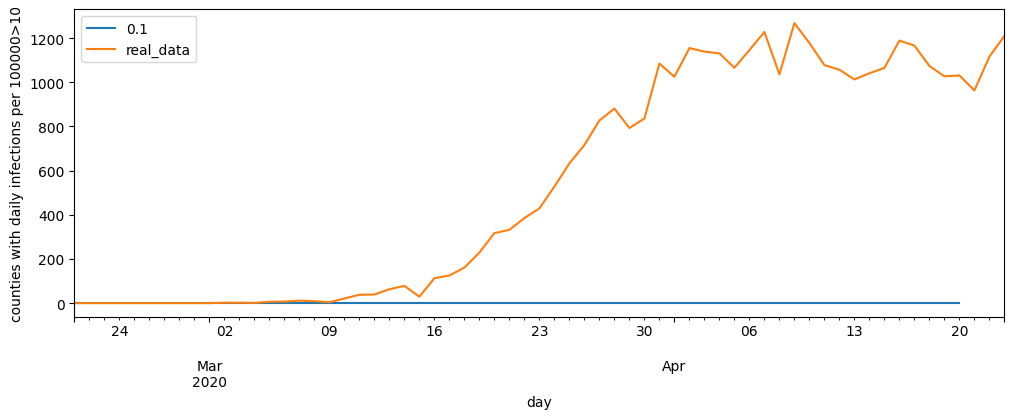

In [38]:
fig, ax = plt.subplots(1,1, figsize=(12, 4))

# plt.plot(county_ode,label='metapopulation',color='red')
df_num_counties.plot(ax=ax)
df_real.plot(ax=ax)
# df_num_counties10.plot(ax=ax)

plt.legend()
plt.xlabel('day')
plt.ylabel('counties with daily infections per 100000>10')
# plt.ylim(-100,1400)